# Loading a trained solvation GNN model

In [1]:
import sys, os, glob
from rdkit import Chem
import pandas as pd
import numpy as np
import torch

from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 200,200                

from rdkit.Chem.Draw import SimilarityMaps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def save_rdfig(fig, name):
    fig.savefig(f"/scratch/sn29/klow12/solvE/PNGs/{name}", bbox_inches="tight", dpi=300)

# DAAQs

In [4]:
from gnn.prediction.prediction import predict_from_file
from gnn.data.dataset import load_mols_labels
from gnn.prediction.visualisation import eval_with_weights
from gnn.prediction.load_model import load_dataset, load_model

Using backend: pytorch


First, we will predict the solvation free energies of the DAAQs using a model trained on the random split dataset. The function ```predict_from_file``` takes four arguments:

* `model_path`: the path to the saved model
* `dataset_file`: the file containing the SMILES strings of the solute and solvent, plus a column containing the experimental "true" $\Delta G{solv}$ values. Since there aren't any experimental data for this particular dataset, we just fill the column with 0s.
* `solvent_extra_features`: if we have used the dielectric constants in the loaded model, we need to include the dielectric constants for each solvent in dataset_file.
* `device`: whether or not to use GPU-version of PyTorch.


Here we are only loading one of the random seed trained models. In the paper we took the average predictions from 5 trained models with different starting seeds.

In [6]:
# Baseline model
preds_daaq_IM, _ = predict_from_file(
    model_path='/fs03/sn29/klow12/solvE/gnn/jobs/xtb/random_split/x-attn/plusDC/logdir/230',
     dataset_file='/scratch/sn29/klow12/solvE/gnn/jobs/test_data/DAAQs/testDAAQs.csv',
    solvent_extra_features='/scratch/sn29/klow12/solvE/gnn/jobs/test_data/DAAQs/dielectrics.csv',
     device=device)

In [8]:
preds_daaq_IM

array([-17.15908792, -17.56841391, -21.96485126, -23.30396817,
       -24.21382888, -24.57642688, -26.37301661, -26.78388617])

### View IM weights

In [9]:
#Load model and dataset
ids_daaq, targets_daaq, predictions_daaq, solu_w, solv_w  = eval_with_weights(
        model_path='/fs03/sn29/klow12/solvE/gnn/jobs/xtb/random_split/x-attn/plusDC/logdir/230',
         data_file='/scratch/sn29/klow12/solvE/gnn/jobs/test_data/DAAQs/testDAAQs.csv',
    solvent_extra_features='/scratch/sn29/klow12/solvE/gnn/jobs/test_data/DAAQs/dielectrics.csv',
     device=device)

In [10]:
daaq_data = load_dataset(
    model_path='/fs03/sn29/klow12/solvE/gnn/jobs/xtb/random_split/x-attn/plusALL/logdir/230',
    dataset_file='/scratch/sn29/klow12/solvE/gnn/jobs/test_data/DAAQs/testDAAQs.csv',
solvent_extra_features='/scratch/sn29/klow12/solvE/gnn/jobs/test_data/DAAQs/dielectrics.csv')

In [55]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600,600

In [15]:
daaq_solu_1 = daaq_data.molecules[-2][0]
daaq_solv_1 = daaq_data.molecules[-2][1]

In [17]:
daaq_solu_1.RemoveAllConformers()
daaq_solv_1.RemoveAllConformers()

We can use rdkit.Draw to see the solute and solvent atom indices.

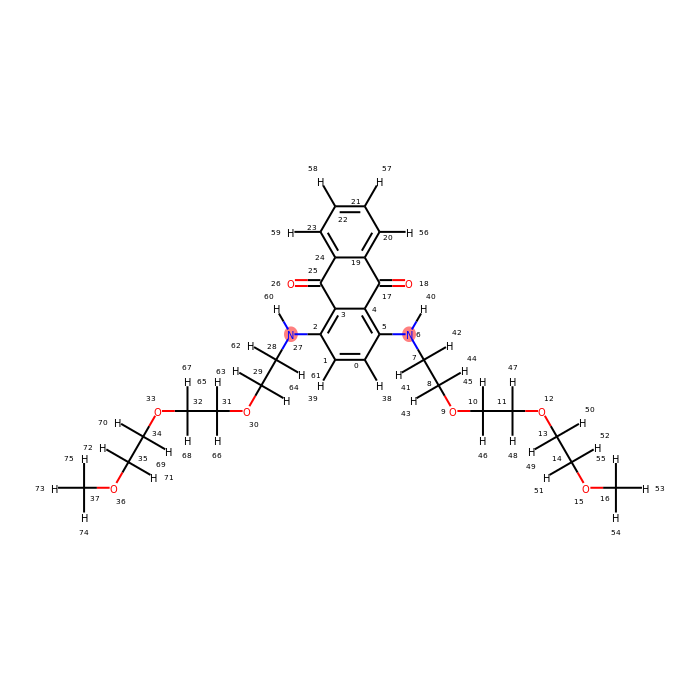

In [20]:
daaq_solu_1

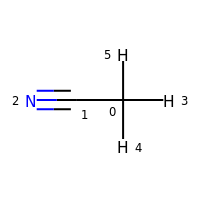

In [26]:
daaq_solv_1

In [21]:
weights_daaq = torch.matmul(solv_w[-2], solu_w[-2].t()).cpu().numpy()
A_daaq = (weights_daaq - np.mean(weights_daaq)) / np.std(weights_daaq)

daaq_solv_1.RemoveAllConformers(); daaq_solu_1.RemoveAllConformers()

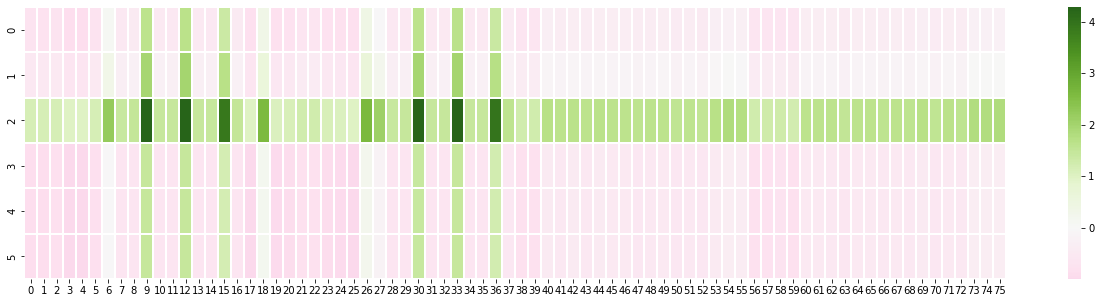

In [23]:
plt.figure(figsize=(22,5))
sns.heatmap(A_daaq, annot=False, fmt='.1f', linewidths=0.4, cmap='PiYG', center=0)
plt.show()

Now we can sum over the rows or columns to get the cumulative contribution of each atom to the solute/solvent:

In [27]:
solvent_cmap_1 = np.zeros(daaq_solv_1.GetNumAtoms())
for i in range(daaq_solu_1.GetNumAtoms()):
        a_weights_1 = A_daaq[:,i]
        solvent_cmap_1 += a_weights_1
        
solute_cmap_1 = np.zeros(daaq_solu_1.GetNumAtoms())
for i in range(daaq_solv_1.GetNumAtoms()):
        weights_1 = A_daaq[i,:]
        solute_cmap_1 += weights_1

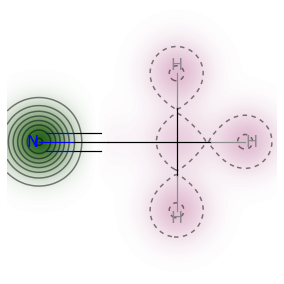

In [28]:
solvent_fig = SimilarityMaps.GetSimilarityMapFromWeights(daaq_solv_1, solvent_cmap_1,
                     size=(150,150))

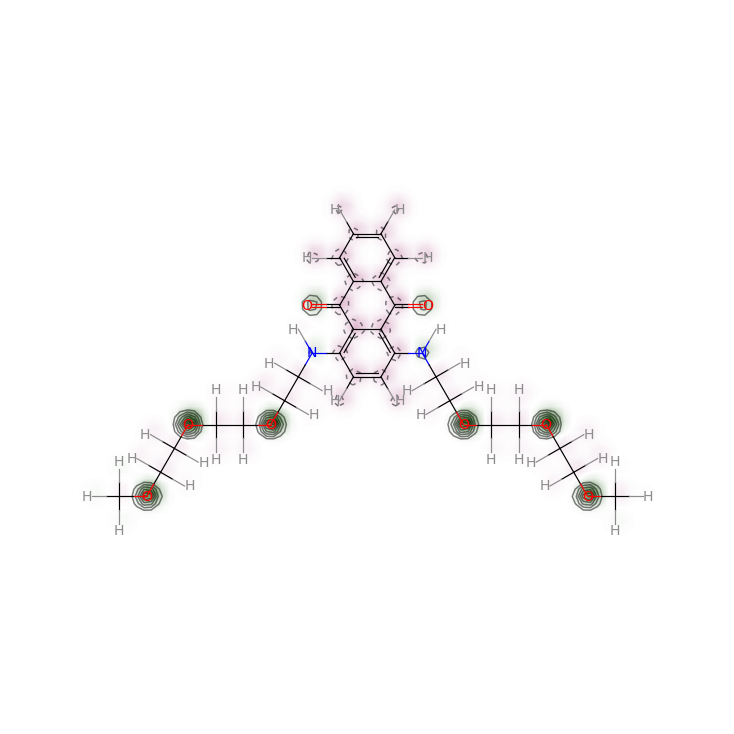

In [30]:
solu_fig = SimilarityMaps.GetSimilarityMapFromWeights(daaq_solu_1, solute_cmap_1, size=(400,400))

The addition of the oxygen atoms in the glycol chain enhances interactions with the polar C=N group in acetonitrile.

What about the interaction in toluene?

In [38]:
daaq_solu_4 = daaq_data.molecules[-1][0]
daaq_solv_4 = daaq_data.molecules[-1][1]

daaq_solu_4.RemoveAllConformers()
daaq_solv_4.RemoveAllConformers()

In [33]:
weights_daaq_4 = torch.matmul(solv_w[-1], solu_w[-1].t()).cpu().numpy()
A_daaq_4 = (weights_daaq_4 - np.mean(weights_daaq_4)) / np.std(weights_daaq_4)

In [39]:
solvent_cmap_4 = np.zeros(daaq_solv_4.GetNumAtoms())
for i in range(daaq_solu_4.GetNumAtoms()):
        a_weights_4 = A_daaq_4[:,i]
        solvent_cmap_4 += a_weights_4
        
solute_cmap_4 = np.zeros(daaq_solu_4.GetNumAtoms())
for i in range(daaq_solv_4.GetNumAtoms()):
        weights_4 = A_daaq_4[i,:]
        solute_cmap_4 += weights_4

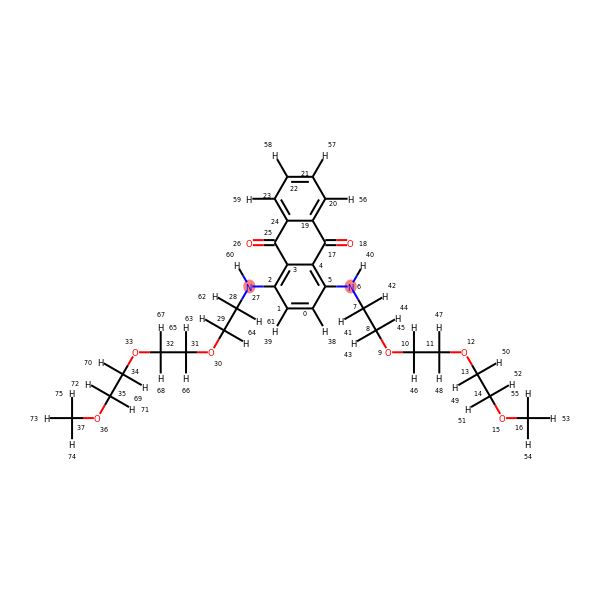

In [56]:
daaq_solu_4

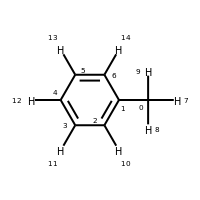

In [42]:
daaq_solv_4

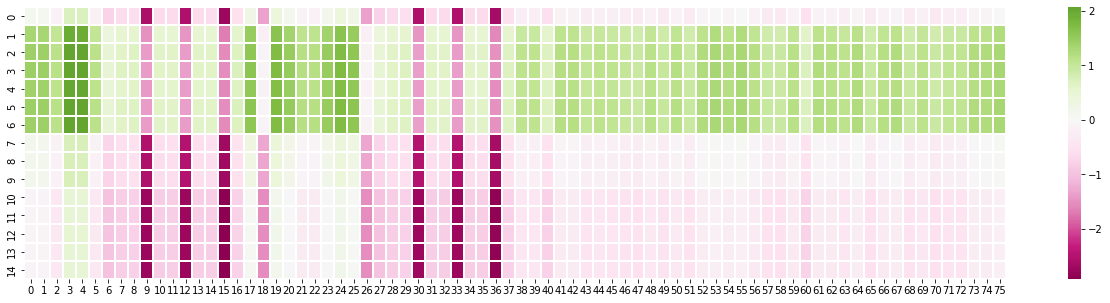

In [40]:
plt.figure(figsize=(22,5))
sns.heatmap(A_daaq_4, annot=False, fmt='.1f', linewidths=0.4, cmap='PiYG', center=0)
plt.show()

In [44]:
solute_cmap_benzene = np.zeros(daaq_solu_4.GetNumAtoms())

for i in range(daaq_solv_4.GetNumAtoms()):
        weights_4 = A_daaq_4[i,:]
        solute_cmap_4 += weights_4

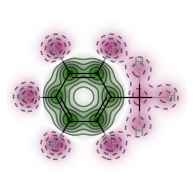

In [46]:
solu_fig = SimilarityMaps.GetSimilarityMapFromWeights(daaq_solv_4, solvent_cmap_4, 
                                                              size=(100,100))

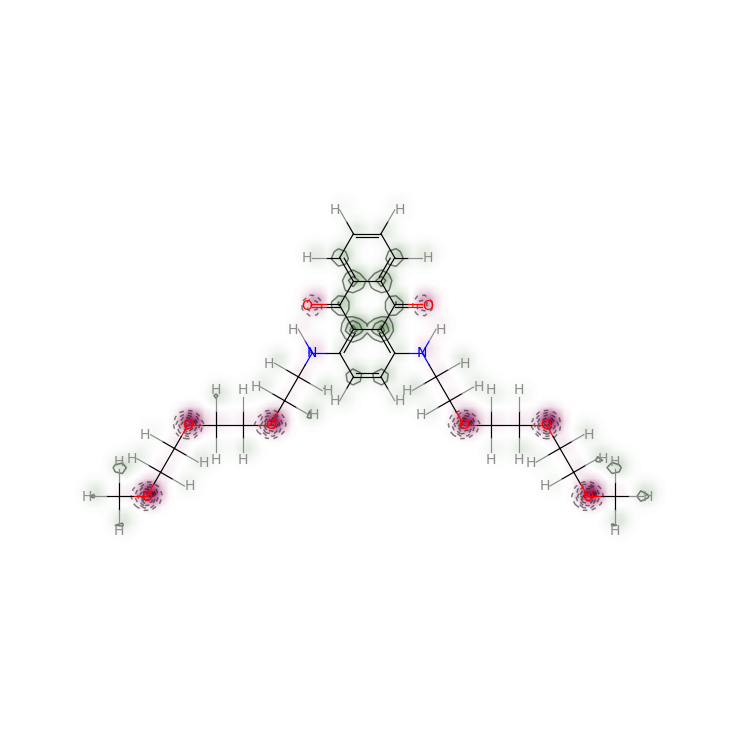

In [48]:
solv_fig_benzene = SimilarityMaps.GetSimilarityMapFromWeights(daaq_solu_4, solute_cmap_4, 
                                                              size=(400,400))

We can also just look at the interaction of the benzene ring only in toluene by summing over those atom indices only:

In [49]:
solute_cmap_benzene = np.zeros(daaq_solu_4.GetNumAtoms())

for i in range(daaq_solv_4.GetNumAtoms()):
    if i in range(1,7):
        weights_4 = A_daaq_4[i,:]
        solute_cmap_benzene += weights_4

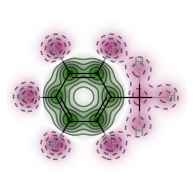

In [50]:
solv_fig = SimilarityMaps.GetSimilarityMapFromWeights(daaq_solv_4, solvent_cmap_4, 
                                                              size=(100,100))

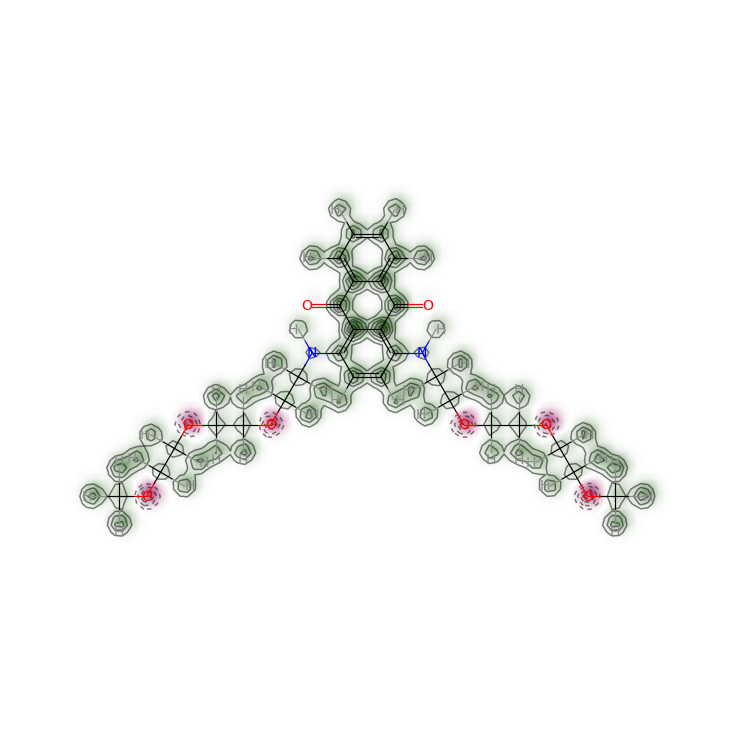

In [53]:
solu_fig_benzene = SimilarityMaps.GetSimilarityMapFromWeights(daaq_solu_4, solute_cmap_benzene, 
                                                              size=(400,400))